# Pipeline segmentation Eva 

`%matplotlib inline` will allow to plot data directly inside the notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In the following 2 cells we are loading all the different library that would be needed for the image segmentation.

In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage.external import tifffile
from skimage import morphology
from skimage import img_as_float
from skimage import filters
from skimage import restoration
from scipy import ndimage as ndi
from skimage import segmentation
from skimage import feature
from skimage import measure
from skimage import util
from skimage.color import label2rgb
from skimage import color
from skimage.color import label2rgb
from IPython.display import HTML

In [4]:
cd ..

/Users/Espenel/Documents/bioimage-analysis/code_git/segmentation_eva


In [5]:
from io_czi import cziReader
from scripts.segmentation import *
from scripts.plot import *
from scripts.display import to_rgb


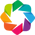

In [6]:
import holoviews as hv
hv.extension('bokeh')
#hv.extension('matplotlib')

In [7]:
plt.rcParams['figure.figsize'] = 7,7
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Introduction

In Python, images are represented as `numpy` arrays. A single-channel, or grayscale, image is a 2D matrix of pixel intensities of shape `(row, column)`. We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`. Multichannel data adds a `channel` dimension in the final position containing color information. 

These conventions are summarized in the table below:


|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

Note that, although, some 3D images are constructed with equal resolution in each dimension. In microscopy, data captured in the Z dimension have (usually) lower resolution than in XY. The distance between pixels in each dimension, called `spacing`, is encoded in a tuple and is accepted as a parameter by some `skimage` functions and can be used to adjust contributions to filters.


Starting a line of code with `!` allow to execute command line statement directly in the notebook:

In [12]:
!ls images

ctrl_150_2.tif          orthogonal_view2.gif    slice_exploreur3.gif
ctrl_glass_40x_fix5.czi slice_exploreur2.gif


In [13]:
path = "images"

In [14]:
filename = "ctrl_150_2.tif"

## Input/Output

Three dimensional data can be loaded with `skimage.io.imread`.

In [15]:
img = io.imread(path + "/" + filename)

In [16]:
print("shape: {}".format(img.shape))
print("dtype: {}".format(img.dtype))
print("range: ({}, {})".format(img.min(), img.max()))

shape: (34, 1024, 1024, 3)
dtype: uint16
range: (0, 65535)


# OPTIONAL - ADJUSTING SPACING

It is possible to access some of the metadata using the Tifffile module form `scikit-image`, more info [here](http://scikit-image.org/docs/dev/api/skimage.external.tifffile.html#skimage.external.tifffile.TiffFile) for the different attributes available. 

In [17]:
with tifffile.TiffFile(path + "/" + filename, is_ome=True) as tif:
    meta = tif.info(pages ='all')
    #img = tif.asarray()
for line in meta.splitlines():
    if 'resolution' in line:
        print(line)
    elif 'slices' in line:
        print(line)
    elif 'unit' in line:
        print(line)
    elif 'space' in line:
        print(line)

* 270 image_description (116s) b'ImageJ=1.51n\nimages=102\nchannels=3\nslices=3
* 282 x_resolution (2I) (4817734, 1000000)
* 283 y_resolution (2I) (4817734, 1000000)
* 296 resolution_unit (1H) 1
* slices: 34
* unit: micron


In [18]:
#print(meta)

In [19]:
# According to the metadata the following XYZ spacing wsa used
original_spacing = np.array([1/(4817734/1000000), 1/(4817734/1000000), 1])

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1/(1/(4817734/1000000)), 1/(1/(4817734/1000000)), 1]

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing[2]

print("microscope spacing: {}\n".format(original_spacing))
print("after rescaling images: {}\n".format(rescaled_spacing))
print("normalized spacing: {}\n".format(spacing))

microscope spacing: [ 0.20756646  0.20756646  1.        ]

after rescaling images: [ 1.  1.  1.]

normalized spacing: [ 1.  1.  1.]



# END OPTIONAL

# Display

Back to our data, first we want to split the 3 channels, for that we will use the numpy `np.transpose` to permute the dimension: 

In [20]:
actin, yap, dapi = img.transpose(3,0,1,2)

In order to visualyse the data, you can use `matplotlib.pyplot.imshow` but it will only allow you to visualize 2D planes. By fixing one axis, we can observe three different views of the image.

In [21]:
print("shape: {}".format(dapi.shape))

shape: (34, 1024, 1024)


In [22]:
def show_planes(image, plane = 17, row = 512, column = 512):
    
    fig, (axes) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

    axes[0].imshow(image[plane])
    axes[0].set_title("Plane = {}".format(plane))
    axes[1].imshow(image[:, row, :], aspect=10)
    axes[1].set_title("Row = {}".format(row))
    axes[2].imshow(image[:, :, column], aspect=10)
    axes[2].set_title("Column = {}".format(column))
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

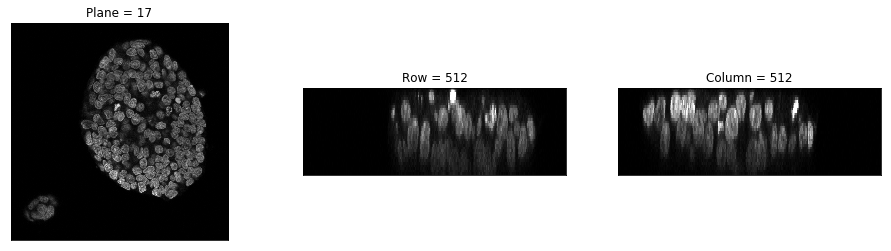

In [23]:
show_planes(dapi)

Note that without changing the "aspect" of the ROw and Column image, it will be to flat to see anything. 

Another, more interactive way to visualye your data is to use [Holoviews](http://holoviews.org/), here I wrote the function `slice_exploreur` function which allow to navigate through the 3rd dimension. 
> Note that if you load all the holoviews figures, you may crash the notebook...

In [ ]:
%%output size=150
%%opts Image (cmap='gray')
%%opts Image [xaxis=None yaxis=None]

slice_exploreur(dapi, i=1, label = "DAPI")

In [6]:
# JUST A GIF EXAMPLE OF WHAT IT LOOKS LIKE
HTML('<img src="images/slice_exploreur2.gif">')

In [ ]:
%output?

If it's to slow to show the images, you can downsample them using i=2 or i=4 ...

In [ ]:
%%output size=100
%%opts Image (cmap='viridis')
%%output backend='matplotlib'
    
ch1 = slice_exploreur(actin, i=2, label = "Actin")
ch2 = slice_exploreur(yap, i=2, label = "YAP")
ch3 = slice_exploreur(dapi, i=2, label = "DAPI")
(ch1+ch2+ch3).cols(1)

I won't go into details on how

In [ ]:
%%output size=150
%%opts Overlay [tabs=True]
    
ch1 = slice_exploreur(actin, i=2, label = "Actin")
ch2 = slice_exploreur(yap, i=2, label = "YAP")
ch3 = slice_exploreur(dapi, i=2, label = "DAPI")
(ch1*ch2*ch3)

In [7]:
# JUST A GIF EXAMPLE OF WHAT IT LOOKS LIKE
HTML('<img src="images/slice_exploreur3.gif">')

`orthogonal_view` function allow to explore your data with an orthognoal (XZ, YZ) view.
> This a nice function but I will recommand to close it when you are done with it

In [ ]:
%%output size=150
%%opts Image (cmap='gray')
%%opts Image [xaxis=None yaxis=None]
orthogonal_view(dapi, i=1)

In [8]:
# JUST A GIF EXAMPLE OF WHAT IT LOOKS LIKE
HTML('<img src="images/orthogonal_view2.gif">')

In [27]:
mask_roi = np.zeros(dapi.shape, dtype = bool)
mask_roi[dapi>filters.threshold_otsu(dapi)*0.1] = 1
roi_ilot = morphology.remove_small_objects(mask_roi, 500000)
bbox = ndi.find_objects(roi_ilot)

In [28]:
dapi_roi = dapi[bbox[0]]
yap_roi = yap[bbox[0]]

(-0.5, 630.5, 776.5, -0.5)

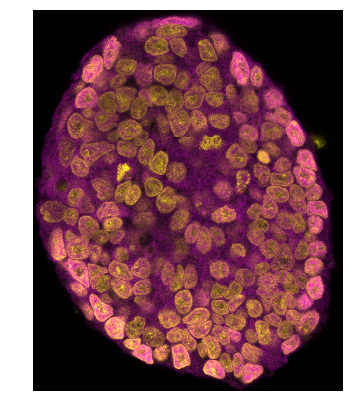

In [29]:
z, x, y = dapi.shape
composite = np.stack((dapi_roi[np.int(z/2)], yap_roi[np.int(z/2)]))
img_rgb = to_rgb(composite, auto = False, bf=False, Channel_0 = 'Yellow', Channel_1 = 'Magenta')
plt.imshow(img_rgb)
plt.axis('off')

# Remove Gaussian noise using total variation Chambolle

In [25]:
dapi_float = img_as_float(dapi_roi)
dapi_float_tvc = restoration.denoise_tv_chambolle(dapi_float, weight = 0.05)

In [26]:
mask_dapi = np.zeros(dapi_float_tvc.shape, dtype = bool)
mask_dapi[dapi_float_tvc>filters.threshold_otsu(dapi_float_tvc)] = 1

# Only do analysis +/-3 steps around highest variance

Since we are not interested in the cells at the top and bottom of the island, we will just look at a thin section in the "middle".

In [27]:
variance = [np.var(image) for _, image in enumerate(mask_dapi)]
idx = np.argmax(variance)

In [28]:
dapi_roi_z = dapi_float_tvc[idx-3:idx+3]

In [29]:
print("shape: {}".format(dapi_roi_z.shape))

shape: (6, 777, 631)


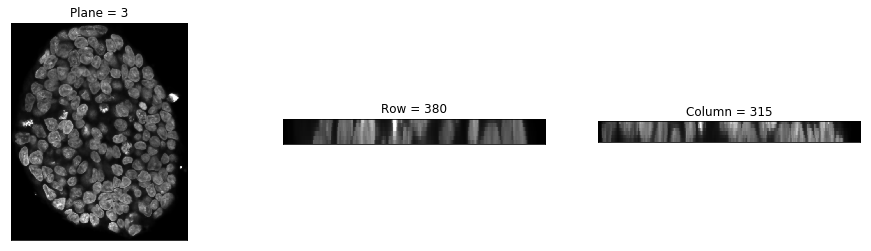

In [30]:
show_planes(dapi_roi_z, 3, 380, 315)

In order to segment the nucleus and the cytoplasm, we will use the [watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) with some "twist". Starting from user-defined markers, the watershed algorithm treats pixels values as a local topography (elevation). The algorithm floods basins from the markers, until basins attributed to different markers meet on watershed lines.

The markers are generated from the distance function. Points furthest from an edge have the highest intensity and should be identified as markers using `skimage.feature.peak_local_max`. Regions with pinch points should be assigned multiple markers. The Watershed lines will be define using the the Sobel operator which is an edge detection algorithm.

In [31]:
sobel = np.empty_like(dapi_roi_z)

for plane, image in enumerate(dapi_roi_z):
    sobel[plane] = filters.sobel(image)

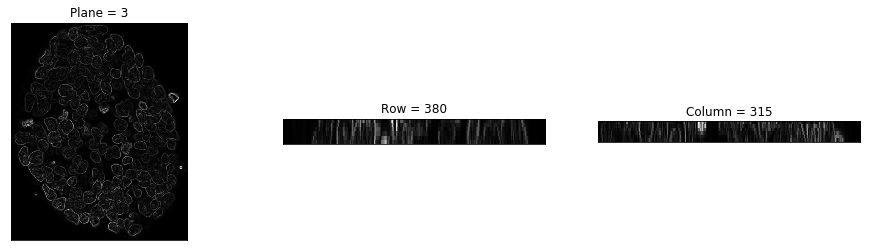

In [32]:
show_planes(sobel, 3, 380, 315)

Then we need to create a mask for the nucleus that we will use for the distance map

In [33]:
def mask_nucleus(dapi_roi_z):
    mask_lst = []
    for img in dapi_roi_z:        
        mask_dapi = dapi_roi_z[3] > filters.threshold_local(dapi_roi_z[3], 81, "mean")
        #d = morphology.selem.diamond(radius=2)
        #mask_dapi = morphology.closing(mask_dapi, d)
        mask_dapi = morphology.remove_small_holes(mask_dapi, 200)
        #mask_dapi = morphology.remove_small_objects(mask_dapi.astype(bool), 1000)
        mask_lst.append(mask_dapi)
    return(np.stack(mask_lst))
    

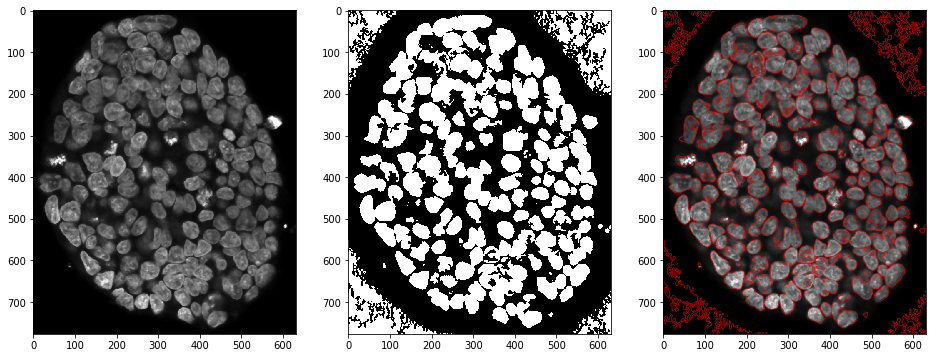

In [34]:
mask_dapi = mask_nucleus(dapi_roi_z)
fig, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(dapi_roi_z[3])
ax[1].imshow(mask_dapi[3])
ax[2].imshow(dapi_roi_z[3]) 
ax[2].contour(mask_dapi[3], colors = 'r', linewidths = 0.1)

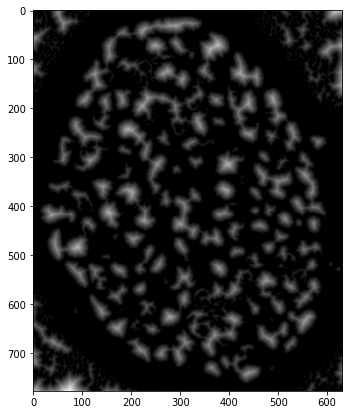

In [35]:
distance_a = ndi.distance_transform_edt(mask_dapi[3])
plt.imshow(distance_a)

From the distance map you can determine the markers.

In [36]:
local_maxi = feature.peak_local_max(distance_a, indices=True, 
                                    exclude_border=False,footprint=np.ones((15, 15)))
markers_lm = np.zeros(distance_a.shape, dtype=np.int)
markers_lm[local_maxi[:,0].astype(np.int), local_maxi[:,1].astype(np.int)] = np.arange(len(local_maxi[:,0])) + 1
markers_lm = morphology.dilation(markers_lm, morphology.disk(5))
markers_3D = np.zeros(dapi_roi_z.shape, dtype = np.int)
markers_3D[3] = markers_lm
markers_3D = ndi.label(markers_3D)[0]

(-0.5, 630.5, 776.5, -0.5)

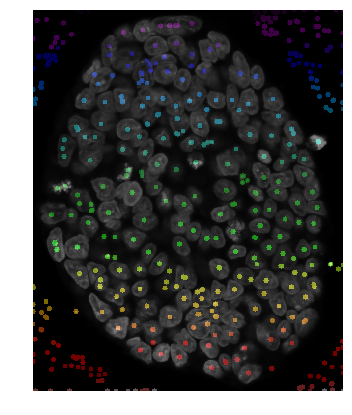

In [37]:
plt.imshow(dapi_roi_z[3])
plt.imshow(markers_3D[3], cmap = "nipy_spectral", alpha = 0.5)
plt.axis('off')
#plt.savefig("/Users/Espenel/Desktop/Bii/markers.png", dpi = 300)

From that plot you can see the a lot of cells have multiple markers, in order to avoid future oversegmentation, ideally, 1 cell should have 1 marker. To accomplish that, you can either smooth the distance map or increase the size of the footprint. 

In [38]:
local_maxi = feature.peak_local_max(distance_a, indices=True, 
                                    exclude_border=False,footprint=np.ones((30, 30)))
markers_lm = np.zeros(distance_a.shape, dtype=np.int)
markers_lm[local_maxi[:,0].astype(np.int), local_maxi[:,1].astype(np.int)] = np.arange(len(local_maxi[:,0])) + 1
markers_lm = morphology.dilation(markers_lm, morphology.disk(5))
markers_large_ft = np.zeros(dapi_roi_z.shape, dtype = np.int)
markers_large_ft[3] = markers_lm
markers_large_ft = ndi.label(markers_large_ft)[0]

In [39]:
smooth_distance = filters.gaussian(distance_a, sigma=4)

local_maxi = feature.peak_local_max(smooth_distance, indices=True, 
                                    exclude_border=False,footprint=np.ones((15, 15)))
markers_lm = np.zeros(distance_a.shape, dtype=np.int)
markers_lm[local_maxi[:,0].astype(np.int), local_maxi[:,1].astype(np.int)] = np.arange(len(local_maxi[:,0])) + 1
markers_lm = morphology.dilation(markers_lm, morphology.disk(5))
markers_smooth = np.zeros(dapi_roi_z.shape, dtype = np.int)
markers_smooth[3] = markers_lm
markers_smooth = ndi.label(markers_smooth)[0]

(-0.5, 630.5, 776.5, -0.5)

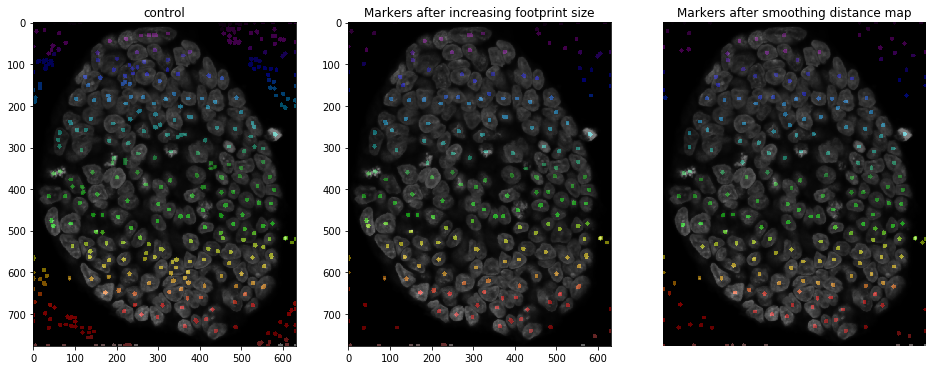

In [40]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(16,8))
ax0.imshow(dapi_roi_z[3])
ax0.imshow(markers_3D[3], cmap = "nipy_spectral", alpha = 0.5)
ax0.set_title("control")
ax1.imshow(dapi_roi_z[3])
ax1.imshow(markers_large_ft[3], cmap = "nipy_spectral", alpha = 0.5)
ax1.set_title("Markers after increasing footprint size")
plt.axis('off')
ax2.imshow(dapi_roi_z[3])
ax2.imshow(markers_smooth[3], cmap = "nipy_spectral", alpha = 0.5)
ax2.set_title("Markers after smoothing distance map")
plt.axis('off')

In [41]:
markers_3D = markers_smooth

For the Watershed segmentation, we are adding an additional compactness argument that makes it harder for markers to flood faraway pixels. This makes the watershed regions more regularly shaped.

In [42]:
dapi_seg = segmentation.watershed(sobel, markers_3D, compactness = 0.001)

(-0.5, 630.5, 776.5, -0.5)

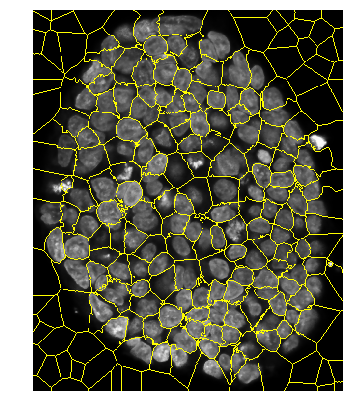

In [43]:
plt.imshow(segmentation.mark_boundaries(dapi_roi_z[3], 
                                        dapi_seg[3]))
plt.axis('off')

I will use the YAP signal to mask the ROI corresponding to the cells

In [44]:
yap_roi = yap[bbox[0]]
yap_roi = yap_roi[idx-3:idx+3]
yap_float = img_as_float(yap_roi)
yap_float_tvc = restoration.denoise_tv_chambolle(yap_float, weight = 0.02)

In [45]:
mask_yap = np.zeros(yap_float_tvc.shape, dtype = bool)
mask_yap[yap_float_tvc>filters.threshold_otsu(yap_float_tvc)*0.1] = True
mask_yap = morphology.remove_small_holes(mask_yap, 5000)

dapi_seg_back = np.copy(dapi_seg)
dapi_seg_back[~mask_yap] = 0

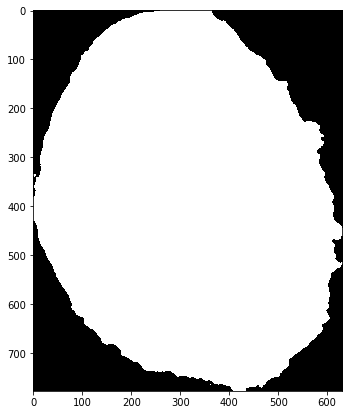

In [46]:
plt.imshow(mask_yap[3])

(-0.5, 630.5, 776.5, -0.5)

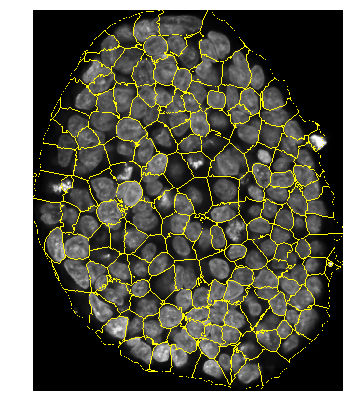

In [47]:
plt.imshow(segmentation.mark_boundaries(dapi_roi_z[3], 
                                        dapi_seg_back[3]))
plt.axis('off')

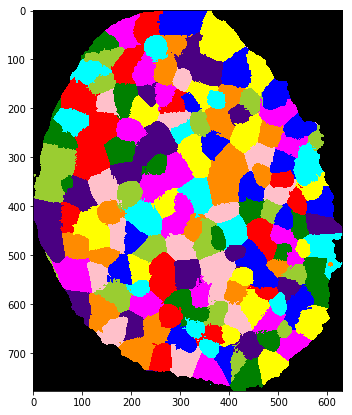

In [48]:
labeled = measure.label(dapi_seg_back)
plt.imshow(label2rgb(labeled[3], bg_label=0))

We now have segmented out the cells, we could have use the Actin signal, however some of the drugs use in the experiments damage the Actin and makes this signal irrelevant. Although this "cell segmentation" is not perfectly accurate, it's consistent between the different treatments. 

What we have to do now is to 1) separate the nucleus from the cytoplasm and 2) clean the the segmentation. For the first step we will use the nucleus mask that we created previously

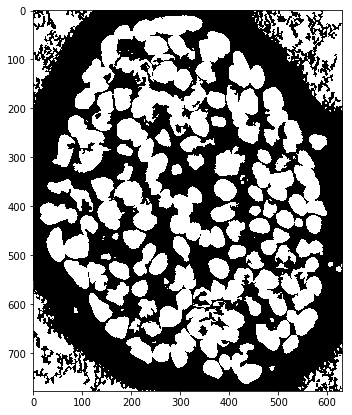

In [49]:
nucleus_mask = np.copy(mask_dapi)
nucleus_mask[nucleus_mask>0] = 1
nucleus_mask = nucleus_mask.astype('bool')
plt.imshow(nucleus_mask[3])

In [50]:
labeled_ext = np.copy(labeled)
labeled[~nucleus_mask] = 0
nucleus = measure.label(labeled)

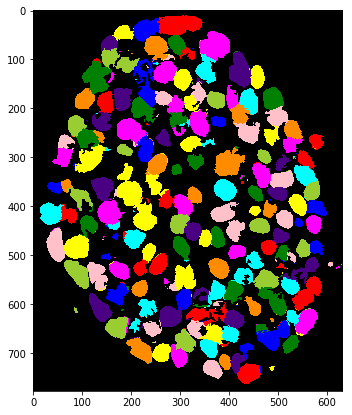

In [51]:
plt.imshow(label2rgb(nucleus[3], bg_label=0))

Now we need to clean a little bit the segmentation, we will use the area of the region that was segmented as well as the intensity.

In [52]:
prop_nucleus = measure.regionprops(nucleus, intensity_image = dapi_roi_z)

In [53]:
nucl_size = [prop.area for prop in prop_nucleus]

In [54]:
intensity = [prop.mean_intensity for prop in prop_nucleus]

In [55]:
cleaned = np.copy(nucleus)
for area, mean_int, region in zip(nucl_size, intensity, prop_nucleus):
    if area < 2000 or mean_int < filters.threshold_otsu(dapi_roi_z)*0.5 or mean_int > filters.threshold_otsu(dapi_roi_z)*3:
        cleaned[tuple(region.coords.T)] = 0

Text(0.5,1,'after cleaning')

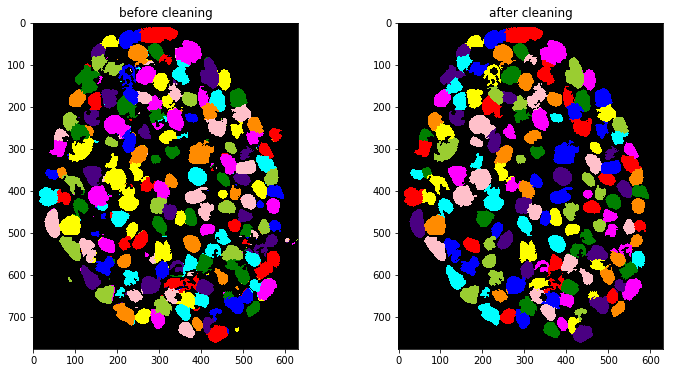

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
ax1.imshow(label2rgb(nucleus[3], bg_label=0))
ax1.set_title("before cleaning")
ax2.imshow(label2rgb(cleaned[3], bg_label=0))
ax2.set_title("after cleaning")

Now we need to work with the cytoplasm, in a first part we will match label for the cytoplasm with the nucleus label. 

In [57]:
prop_cyto = measure.regionprops(labeled_ext, cleaned)

In [58]:
labeled_cyto = np.copy(labeled_ext)
for prop in prop_cyto:
    if prop.max_intensity == 0:
        labeled_cyto[tuple(prop.coords.T)] = 0
    else:
        labeled_cyto[tuple(prop.coords.T)] = prop.max_intensity

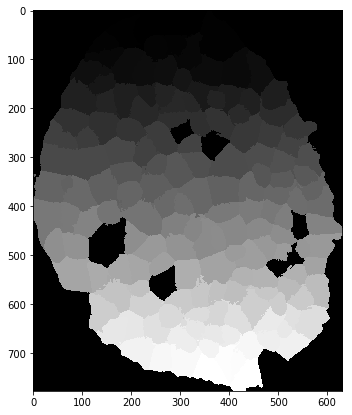

In [59]:
plt.imshow(labeled_cyto[3])

In [60]:
label_ext = np.copy(labeled_cyto)
# We will need that label for later

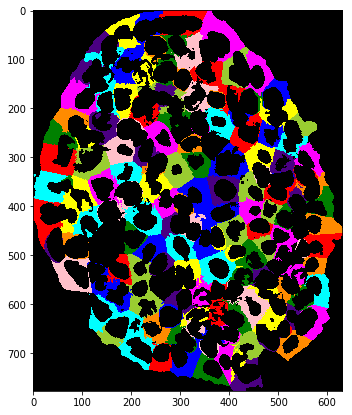

In [61]:
labeled_cyto[nucleus_mask] = 0
plt.imshow(label2rgb(labeled_cyto[3], bg_label=0))

Text(0.5,1,'Edu Segmentation')

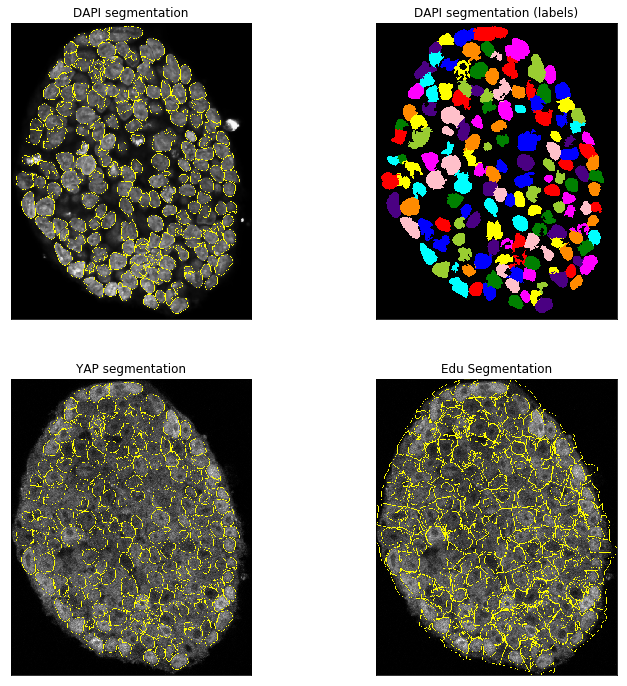

In [62]:
fig, ax = plt.subplots(2,2,figsize = (12,12))

ax[0,0].imshow(segmentation.mark_boundaries(dapi_roi_z[3], 
                                        cleaned[3]))
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('DAPI segmentation')

ax[0,1].imshow(label2rgb(cleaned[3], bg_label=0))
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('DAPI segmentation (labels)')

ax[1,0].imshow(segmentation.mark_boundaries(yap_roi[3], 
                                        cleaned[3]))
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title('YAP segmentation')

ax[1,1].imshow(segmentation.mark_boundaries(yap_roi[3], 
                                        labeled_cyto[3]))

ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_title('Edu Segmentation')


#plt.axis('off')

Finally the last step is to find the external cells vs internal cells.

In [63]:
line_extern = morphology.erosion(
              mask_yap[3],
              morphology.disk(5)) ^ morphology.dilation(mask_yap[3],
              morphology.disk(1))
line_extern = morphology.remove_small_objects(line_extern, 1000)

mask_outside = np.copy(label_ext[3])
mask_outside[~line_extern] = 0

label_outside = measure.regionprops(mask_outside)

label_outside_list = []
for prop in label_outside:
    label_outside_list.append(prop.label)

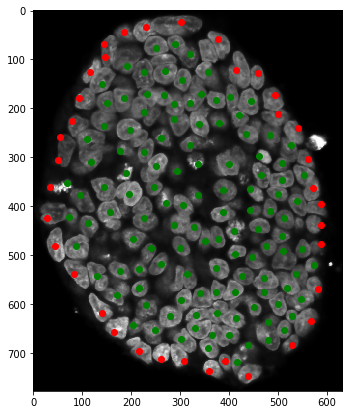

In [64]:
prop_yap = measure.regionprops(label_ext, intensity_image = yap_roi)

plt.imshow(dapi_roi_z[3])

for j in prop_yap:
    if j.label in label_outside_list:
        plt.scatter(j.centroid[2], j.centroid[1], c = 'r')
    if j.label not in label_outside_list:
        plt.scatter(j.centroid[2], j.centroid[1], c = 'g')